In [177]:
import numpy as np
import matplotlib.pyplot as plt

class Reservoir:
    def __init__(self, size, input_size, prune=None):
        self.size = size
        self.input_size = input_size
        self.output_size = input_size
        self.prune = prune
        self.initialize_weights()
    
    def initialize_weights(self):
        self.w_in = np.random.normal(0, np.sqrt(0.002), size=(self.size, self.input_size))
        self.w_res = np.random.normal(0, np.sqrt(2/self.size), size=(self.size, self.size))
        if self.prune is not None:
            self.prune_weights(self.w_in, self.prune[0])
            self.prune_weights(self.w_res, self.prune[1])
        
    def prune_weights(self, w, fraction):
        n_elements = int(np.floor(fraction * w.shape[0] * w.shape[1]))
        indicies = np.random.permutation(w.shape[0] * w.shape[1])[0:n_elements]
        for idx in indicies:
            i = idx // w.shape[1]
            j = idx % w.shape[1]
            w[i,j] = 0.0
        
    def train(self, x, k):
        r = np.zeros((self.size,))
        X = np.zeros((x.shape[0]-1, self.size))
        for i in range(x.shape[0]-1):
            r = np.tanh(self.w_res @ r + self.w_in @ x[i,:])
            X[i,:] = r
        y = x[1::,:]
        # Ridge regression
        self.w_out = y.T @ X @ np.linalg.inv(X.T @ X + k * np.identity(self.size))
    
    def predict(self, x, steps):
        r = np.zeros((self.size,))
        # Feed x through reservoir
        for i in range(x.shape[0]):
            r = np.tanh(self.w_res @ r + self.w_in @ x[i,:])
        out = np.zeros((steps, self.output_size))
        # Make further predictions
        for i in range(steps):
            out[i,:] = self.w_out @ r
            r = np.tanh(self.w_res @ r + self.w_in @ out[i,:])
        return out

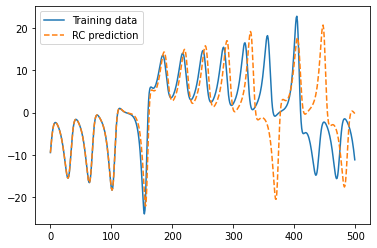

In [182]:
training_data = np.genfromtxt('training-set.csv', delimiter=',').T
test_data = np.genfromtxt('test-set-1.csv', delimiter=',').T

reservoir_size = 500
k = 0.01
reservoir = Reservoir(reservoir_size, training_data.shape[1])
reservoir.train(training_data, k)

# Predict already know data to see performance of the network
train_pred = reservoir.predict(training_data[0:1000], 500)

# Plot results
plt.plot(np.arange(500), training_data[1000:1500,1], label='Training data')
plt.plot(np.arange(500), train_pred[:,1], '--', label='RC prediction')
plt.legend()

# Make prediction from test data
test_pred = reservoir.predict(test_data, 500)

np.savetxt('prediction.csv', test_pred[:,1], fmt='%.6f', delimiter=',')